## OPIS: 

## 1. Pobieranie danych


In [1]:
import os
import cv2
import numpy as np

In [2]:
age_classes = 6

def class_labels_reassign(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [3]:
# Dane wkładane są do listy z {age_classes} wierszami. 
# W każym wierszu znajduje się zdjęcie/wiek odpowiadający danej grupie wiekowej.

def load_data(data_folder, img_width, img_height, N):
    images = []
    ages = []
    
    for _ in range(age_classes):
        new_list1 = []  
        new_list2 = []
        images.append(new_list1) 
        ages.append(new_list2)
        
    i = 0
    for filename in os.listdir(data_folder):
            img = cv2.imread(os.path.join(data_folder, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            img = cv2.resize(img, (img_width, img_height))  
            age = int(filename.split('_')[0])  
            age_class = class_labels_reassign(age) - 1
            
            ages[age_class].append(age)
            images[age_class].append(img)
            
            if(i==N and N!=-1):
                break
            i = i + 1
            
    return images, ages

In [4]:
# Parametry
img_width = 200
img_height = 200


In [5]:
# Pobierz dane

(img1, ages1) = load_data('./dataset/UTKface dataset/part1', img_width, img_height, 100)
(img2, ages2) = load_data('./dataset/UTKface dataset/part2', img_width, img_height, 100)
(img3, ages3) = load_data('./dataset/UTKface dataset/part3', img_width, img_height, 100)

In [6]:
# Połącz listy, łacząc wszystkie grupy wiekowe

def concatenate_lists_age_class(*lists):
    output_lists = []
    
    for _ in range(age_classes):
        new_list = []  # Tworzymy nową pustą listę
        output_lists.append(new_list) 
    
    for list_ in lists:
        i = 0
        for l in list_:
            output_lists[i].extend(l)
            i = i + 1
    return output_lists

images = concatenate_lists_age_class(img1,img2,img3)
ages = concatenate_lists_age_class(ages1,ages2,ages3)

## 2. Augmentacja danych

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
def augment_image(image, N=5):
    
    # Wczytaj obraz za pomocą Keras
    image_array = image
    image_array = np.expand_dims(image_array, axis=0)

    # Konfiguracja generatora augmentacji
    generator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Wygeneruj N zaaugmentowanych obrazów
    augmented_images = []
    augmented_images.append(np.array(image).astype(float))
    for _ in range(N):
        augmented_image = generator.flow(image_array).next()[0]
        augmented_images.append(augmented_image)

    return augmented_images

In [9]:
def augment_list(images, ages, N=5):
    images_output = []
    ages_output = []
    
    for i, (image, age) in enumerate(zip(images, ages)):

        augmented_images = augment_image(image, N)

        augmented_ages = [age] * (N + 1)
        
        images_output.extend(augmented_images)
        ages_output.extend(augmented_ages)
        
    return (images_output, ages_output)

In [10]:
# wektor ile zdjęć augmentować dla danej grupy wiekowe
# Na przykład: jeżeli i-ty element wektora równa się 5 to funkcja stworzy 5 przekształconych zdjęć + 1 zdjęcie oryginalne
augment_amount_for_class = [5, 5, 5, 7, 8, 15]

for i, N in enumerate(augment_amount_for_class):
    images[i], ages[i] = augment_list(images[i], ages[i], N)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


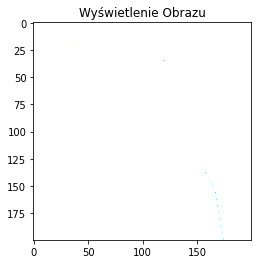

In [11]:
images[1][1]
plt.imshow(augment_image(images[1][10])[3],vmin=0.0, vmax=1.0)# cmap='gray' dla obrazu czarno-białego vmin=0.0, vmax=1.0
plt.title('Wyświetlenie Obrazu')
plt.show()


## 3. Zbiory treningowe

In [12]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [13]:
# Łączenie wiele list w jedną listę.
def concatenate_lists(*lists):
    output_lists = []

    for list_ in lists:
        new_list.extend(list_)
        
    return output_lists

# Bierze listę zdjęć/wieków podzieloną na klasy wiekowe i łaczy w jedną listę.
def merge_lists(lists):
    output_lists = []
    i = 0
    for _ in range(age_classes):
        output_lists.extend(lists[i]) 
        i = i + 1
    
    return output_lists

In [14]:
# Przygotowanie zbiorów testowych/treningowych.
seed = 42

images = merge_lists(images)
ages = merge_lists(ages)

images = np.array(images)
ages = np.array(ages)

# Podziel dane na dane treningowe (80%) i dane testowe (20%)
train_images, test_images, train_ages, test_ages = train_test_split(images, ages, test_size=0.2, random_state=seed)

In [15]:
# Funkcja do przetwarzania obrazów
# Tutaj możemy na przykład przerobić obraz na czarno-biały.

def preprocess_image(image, age):
    image = image / 255.0  # Normalizacja wartości pikseli do zakresu [0, 1]
    
    return image, age

In [16]:
batch_size_param = 512

# Utwórz dataset dla danych treningowych
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_ages))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)

# Utwórz dataset dla danych testowych
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_ages))
test_dataset = test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)

In [17]:
# Wyświetl rozmiary danych treningowych i walidacyjnych
print(f"Liczba obrazów treningowych: {len(train_images)}")
print(f"Liczba wieków treningowych: {len(train_ages)}")
print(f"Liczba obrazów walidacyjnych: {len(test_images)}")
print(f"Liczba wieków walidacyjnych: {len(test_ages)}")

Liczba obrazów treningowych: 1710
Liczba wieków treningowych: 1710
Liczba obrazów walidacyjnych: 428
Liczba wieków walidacyjnych: 428


# 4. Tworzenie modelu

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [19]:
model = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(img_width, img_height, 3)))    # 3rd dim = 1 for grayscale images.
model.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
model.add(GlobalAveragePooling2D())
# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
model.add(Dense(132, activation='relu'))
# Output layer with 7 nodes (equal to the no. of classes).
model.add(Dense(7, activation='softmax'))

model.add(Dense(1, activation='linear'))  # Warstwa wyjściowa z jednym neuronem (regresja)

model.summary()

# Compiling the above created CNN architecture.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 23, 23, 128)      0

In [20]:
checkpoint_path  = './checkpoints/UTK_faces/age_model_checkpoint.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [ ]:
# Trenowanie modelu

model_history = model.fit(train_dataset, epochs=10, batch_size=batch_size_param, shuffle=True, validation_data=(test_images, test_ages))

# 5. Testowanie Modelu

In [ ]:
#Historia trenowania

train_loss = model_history.history['loss']
test_loss = model_history.history['val_loss']
train_accuracy = model_history.history['accuracy']
test_accuracy = model_history.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


In [ ]:
final_score = model.evaluate(test_dataset, verbose=1)
# Printing the relevant score summary.
final_labels = model.metrics_names
print(f'CNN model {final_labels[0]} \t\t= {round(final_score[0], 3)}')
print(f'CNN model {final_labels[1]} \t= {round(final_score[1], 3)}')


In [ ]:
# Saving the model as a h5 file for possible use later.
saved_model_path = './models_saved/UTK_faces.h5'
model.save(saved_model_path, save_format='h5')

In [ ]:
# Generating predictions from the model above.
final_pred = model.predict(test_dataset)
final_pred = final_pred.argmax(axis=-1)

# Generating a confusion matrix based on above predictions.
conf_mat = confusion_matrix(test_ages, final_pred)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)
    
    # Exporting plot image in PNG format.
    #plt.savefig(f'/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/{export_as}.png', bbox_inches='tight');



In [ ]:
cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))

plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()